In [108]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from PIL import Image
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cpu


In [98]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [99]:
# Download and load training data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

# Download and load test data
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [109]:
target_class = 3  # 'cat'

# Convert CIFAR-10 dataset labels to binary: 1 = cat, 0 = not cat
def convert_to_binary(dataset):
    dataset.targets = [1 if label == target_class else 0 for label in dataset.targets]
    return dataset

# Apply conversion to binary classification
trainset = convert_to_binary(trainset)
testset = convert_to_binary(testset)

# Use subset to make it faster (5000 train, 1000 test)
train_subset = Subset(trainset, range(5000))
test_subset = Subset(testset, range(1000))

# DataLoaders
trainLoader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

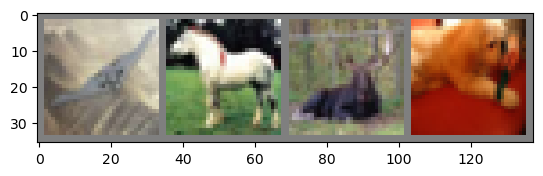

plane plane plane plane


In [110]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)


imshow(make_grid(images))
# print labels
print(' '.join(f'{classes[labels[i]]:5s}' for i in range(4)))



In [111]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

In [112]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):  # keep it light
    model.train()
    running_loss = 0.0
    for images, labels in trainLoader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

KeyboardInterrupt: 

In [104]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = torch.sigmoid(model(images))
        preds = outputs > 0.5
        correct += (preds.squeeze().long() == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 89.80%


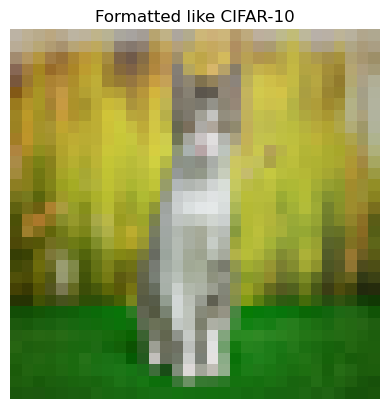

tensor([[[[ 0.4667,  0.4824,  0.4588,  ...,  0.4353,  0.3882,  0.3725],
          [ 0.4353,  0.4588,  0.4353,  ...,  0.3725,  0.3412,  0.3333],
          [ 0.2784,  0.3961,  0.3961,  ...,  0.3647,  0.3098,  0.2471],
          ...,
          [-0.7804, -0.7412, -0.7647,  ..., -0.7412, -0.7804, -0.7725],
          [-0.7725, -0.7647, -0.8039,  ..., -0.7569, -0.8039, -0.8196],
          [-0.7961, -0.7804, -0.7882,  ..., -0.8196, -0.8196, -0.8039]],

         [[ 0.3961,  0.3725,  0.3333,  ...,  0.3804,  0.3020,  0.3098],
          [ 0.3333,  0.3333,  0.3020,  ...,  0.2941,  0.2235,  0.2392],
          [ 0.0980,  0.1765,  0.1686,  ...,  0.2549,  0.1843,  0.1373],
          ...,
          [-0.2784, -0.2235, -0.2235,  ..., -0.2157, -0.2706, -0.2784],
          [-0.2784, -0.2549, -0.2863,  ..., -0.2627, -0.3255, -0.3569],
          [-0.3176, -0.3020, -0.3020,  ..., -0.3333, -0.3490, -0.3412]],

         [[ 0.2627,  0.1529,  0.0745,  ...,  0.2078,  0.0980,  0.1216],
          [ 0.1529,  0.0510, -

In [105]:
# Transform that mimics CIFAR-10 exactly
cifar_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Force it to CIFAR size
    transforms.ToTensor(),        # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Match training
])

def format_like_cifar(img_path):
    img = Image.open(img_path).convert("RGB")
    img_32 = img.resize((32, 32))           # Just for preview
    img_tensor = cifar_transform(img).unsqueeze(0).to(device)  # For model

    # Preview to see what the model "sees"
    plt.imshow(img_32)
    plt.title("Formatted like CIFAR-10")
    plt.axis("off")
    plt.show()

    return img_tensor

format_like_cifar("cat_image.jpg")

In [ ]:
predict_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Match CIFAR-10 image size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Match training
])

def predict_image(img_path, model):
    model = model.to(device)
    model.eval()

    img = Image.open(img_path).convert("RGB")
    img_tensor = predict_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.sigmoid(output).item()

    result = "Cat" if prob > 0.5 else "Not Cat"
    print(f"Prediction: {result} (confidence: {prob:.2f})")

    # Show the image with result title
    plt.imshow(img.resize((128, 128)))  # Upsize just for better display
    plt.title(result)
    plt.axis("off")
    plt.show()

Prediction: Not Cat ❌ (confidence: 0.01)


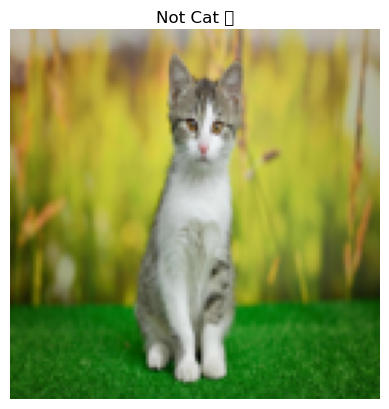

In [107]:
predict_image("cat_image.jpg", model)